In [1]:
import numpy as np
import rosbag
import pandas as pd
import csv
import rospy
import math
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
import rospkg
from scipy.spatial.transform import Rotation as Rot
import plotly
import sympy as sym 
from sympy import *

# Functions

### Forward kinematic

In [2]:
def Forward_kinematic(Theta1,Theta2): # theta1 and theta2 are in Radian
    alpha = Symbol('alpha') 
    beta = Symbol('beta')
#     alpha = math.pi/4
#     beta = math.pi/4
    Ahat = 1/2 * (Theta1 - Theta2)
#     gamma = 2 * np.arctan2((np.sin(alpha)*np.cos(Ahat)+np.sqrt((np.sin(beta)**2)-(np.sin(alpha)*np.sin(Ahat))**2))/(np.cos(alpha)*np.cos(beta)),(np.sin(alpha)*np.cos(Ahat)-np.sqrt((np.sin(beta)**2)-(np.sin(alpha)*np.sin(Ahat))**2))/(np.cos(alpha)*np.cos(beta)))
    gamma = 2 * np.arctan((np.sin(alpha)*np.cos(Ahat)+np.sqrt((np.sin(beta)**2)-(np.sin(alpha)*np.sin(Ahat))**2))/(np.cos(alpha)+np.cos(beta)))
    phi = 1/2 * (Theta1 + Theta2)
    return(gamma*180/math.pi, phi*180/math.pi)

### Inverse kinematic

In [3]:
def Inverse_kinematic(gamma,phi): # gamma and phi are in Radian
    alpha = Symbol('alpha') 
    beta = Symbol('beta')
#     alpha = math.pi/4
#     beta = math.pi/4
    Theta1 = phi + np.arccos(((np.cos(beta))-(np.cos(gamma)*(np.cos(alpha))))/((np.sin(gamma))*(np.sin(alpha))))
    Theta2 = phi - np.arccos(((np.cos(beta))-(np.cos(gamma)*(np.cos(alpha))))/((np.sin(gamma))*(np.sin(alpha))))
    return(Theta1*180/math.pi, Theta2*180/math.pi)

### Rotation Kinematic matrix

In [4]:
# in this function we get for theta and compute the relative rotation matrix between these this two sequence
def DeltaRotationKinematic(theta__11,theta__12,theta__21,theta__22, alpha, beta):
    return np.mat([[(((((sym.cos(theta__11) * sym.cos(theta__21) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 4 + ((-2 * sym.cos(theta__21) ** 2 + 1) * sym.cos(theta__11) ** 2 + (-2 * sym.sin(theta__11) * sym.sin(theta__21) + 1) * sym.cos(theta__21) * sym.cos(theta__11) + sym.cos(theta__21) ** 2) * sym.cos(alpha) ** 2 + (sym.cos(theta__21) ** 2 - 1) * sym.cos(theta__11) ** 2 + sym.cos(theta__11) * sym.cos(theta__21) * sym.sin(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) ** 2 + 1) * sym.cos(theta__21 / 2 + theta__22 / 2) + (sym.cos(alpha) + 1) * sym.sin(theta__21 / 2 + theta__22 / 2) * (sym.cos(alpha) - 1) * (sym.cos(theta__11) * (sym.cos(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) - sym.cos(theta__21) ** 2 * sym.sin(theta__11) + sym.sin(theta__11) - sym.sin(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__21) * (sym.cos(theta__11) ** 2 * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11) * sym.cos(theta__11) - sym.sin(theta__21)))) * sym.cos(theta__11 / 2 + theta__12 / 2) + (-(sym.cos(theta__21) * (sym.cos(theta__11) ** 2 * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11) * sym.cos(theta__11) + sym.sin(theta__11) - sym.sin(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) * (sym.cos(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) - sym.cos(theta__21) ** 2 * sym.sin(theta__11) + sym.sin(theta__11))) * (sym.cos(alpha) + 1) * (sym.cos(alpha) - 1) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * (((sym.cos(theta__21) ** 2 - 1) * sym.cos(theta__11) ** 2 + sym.cos(theta__11) * sym.cos(theta__21) * sym.sin(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) ** 2 - sym.sin(theta__11) * sym.sin(theta__21) + 1) * sym.cos(alpha) ** 4 + ((-2 * sym.cos(theta__21) ** 2 + 1) * sym.cos(theta__11) ** 2 - 2 * sym.cos(theta__11) * sym.cos(theta__21) * sym.sin(theta__11) * sym.sin(theta__21) + sym.cos(theta__21) ** 2 + sym.sin(theta__11) * sym.sin(theta__21)) * sym.cos(alpha) ** 2 + sym.cos(theta__11) * sym.cos(theta__21) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21)))) * sym.sin(theta__11 / 2 + theta__12 / 2)) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - ((sym.cos(theta__11) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 2 - sym.cos(theta__11) ** 2 * sym.cos(theta__21) + (-sym.sin(theta__11) * sym.sin(theta__21) + 1) * sym.cos(theta__11) + sym.cos(theta__21)) * sym.cos(theta__11 / 2 + theta__12 / 2) - ((sym.cos(theta__11) ** 2 * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11) * sym.cos(theta__11) + sym.sin(theta__11) - sym.sin(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) ** 2 * sym.sin(theta__21) + sym.cos(theta__21) * sym.sin(theta__11) * sym.cos(theta__11) - sym.sin(theta__11)) * sym.sin(theta__11 / 2 + theta__12 / 2)) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.sin(alpha) * sym.cos(alpha)) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (((sym.cos(theta__21) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 2 - sym.cos(theta__11) * sym.cos(theta__21) ** 2 - sym.sin(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) + sym.cos(theta__11) + sym.cos(theta__21)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * ((sym.cos(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) - sym.cos(theta__21) ** 2 * sym.sin(theta__11) + sym.sin(theta__11) - sym.sin(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) + sym.cos(theta__21) ** 2 * sym.sin(theta__11) + sym.sin(theta__21))) * sym.sin(alpha) * sym.cos(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + (sym.cos(alpha) + 1) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (sym.cos(alpha) - 1) * (1 + (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 2))) / sym.sin(beta) ** 2,((-((-sym.cos(theta__11) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * (sym.sin(theta__11) - sym.sin(theta__21)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * (sym.cos(theta__11) * (sym.cos(theta__11) - sym.cos(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) ** 2 + sym.cos(theta__11) * sym.cos(theta__21) + 1)) * sym.cos(theta__11 / 2 + theta__12 / 2) + sym.sin(theta__11 / 2 + theta__12 / 2) * (((sym.cos(theta__11) ** 2 + sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 2 - sym.cos(theta__11) ** 2 - sym.sin(theta__11) * sym.sin(theta__21)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__11) * sym.sin(theta__21 / 2 + theta__22 / 2) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * (sym.cos(theta__11) - sym.cos(theta__21)))) * sym.cos(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + ((sym.cos(theta__11) * (sym.cos(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) ** 2 * sym.sin(theta__21) + sym.cos(theta__21) * sym.sin(theta__11) * sym.cos(theta__11) + sym.sin(theta__21)) * sym.cos(theta__11 / 2 + theta__12 / 2) + sym.sin(theta__11 / 2 + theta__12 / 2) * ((sym.cos(theta__11) ** 2 * sym.cos(theta__21) + sym.cos(theta__11) * sym.sin(theta__11) * sym.sin(theta__21) - sym.cos(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) ** 2 * sym.cos(theta__21) - sym.cos(theta__11) * sym.sin(theta__11) * sym.sin(theta__21))) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.sin(alpha)) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * ((((-sym.sin(theta__11) + sym.sin(theta__21)) * sym.cos(alpha) ** 2 - sym.sin(theta__21)) * sym.cos(theta__21 / 2 + theta__22 / 2) + ((sym.cos(theta__11) - sym.cos(theta__21)) * sym.cos(alpha) ** 2 + sym.cos(theta__21)) * sym.sin(theta__21 / 2 + theta__22 / 2)) * sym.sin(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.cos(alpha) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * (sym.cos(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11)))) / sym.sin(beta) ** 2,((((sym.cos(theta__21) * sym.cos(alpha) ** 2 - sym.cos(theta__21)) * sym.cos(theta__11) ** 2 + ((sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 2 - sym.sin(theta__11) * sym.sin(theta__21)) * sym.cos(theta__11) + sym.cos(theta__21)) * sym.cos(theta__11 / 2 + theta__12 / 2) - sym.sin(theta__11 / 2 + theta__12 / 2) * ((sym.sin(theta__21) * sym.cos(alpha) ** 2 - sym.sin(theta__21)) * sym.cos(theta__11) ** 2 - sym.cos(theta__21) * sym.sin(theta__11) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * sym.cos(theta__11) + sym.cos(alpha) ** 2 * (sym.sin(theta__11) - sym.sin(theta__21)))) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - sym.sin(alpha) * sym.cos(alpha) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21) - 1)) * sym.sin(alpha) / sym.sin(beta)],[((((-sym.cos(theta__21) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * (sym.sin(theta__11) - sym.sin(theta__21)) * sym.cos(theta__11 / 2 + theta__12 / 2) + (sym.cos(theta__21) * (sym.cos(theta__11) - sym.cos(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) * sym.cos(theta__21) + sym.cos(theta__21) ** 2 - 1) * sym.sin(theta__11 / 2 + theta__12 / 2)) * sym.cos(theta__21 / 2 + theta__22 / 2) + (((-sym.cos(theta__21) ** 2 - sym.sin(theta__11) * sym.sin(theta__21) + 1) * sym.cos(alpha) ** 2 + sym.cos(theta__21) ** 2 + sym.sin(theta__11) * sym.sin(theta__21)) * sym.cos(theta__11 / 2 + theta__12 / 2) + sym.sin(theta__21) * sym.sin(theta__11 / 2 + theta__12 / 2) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * (sym.cos(theta__11) - sym.cos(theta__21))) * sym.sin(theta__21 / 2 + theta__22 / 2)) * sym.cos(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.sin(alpha) * (((-sym.cos(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) + sym.cos(theta__21) ** 2 * sym.sin(theta__11)) * sym.cos(alpha) ** 2 + sym.cos(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) - sym.cos(theta__21) ** 2 * sym.sin(theta__11) + sym.sin(theta__11)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * ((sym.cos(theta__11) * sym.cos(theta__21) ** 2 + sym.sin(theta__11) * sym.sin(theta__21) * sym.cos(theta__21) - sym.cos(theta__11)) * sym.cos(alpha) ** 2 - sym.cos(theta__11) * sym.cos(theta__21) ** 2 - sym.sin(theta__11) * sym.sin(theta__21) * sym.cos(theta__21)))) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - ((((-sym.sin(theta__11) + sym.sin(theta__21)) * sym.cos(alpha) ** 2 + sym.sin(theta__11)) * sym.cos(theta__11 / 2 + theta__12 / 2) + ((sym.cos(theta__11) - sym.cos(theta__21)) * sym.cos(alpha) ** 2 - sym.cos(theta__11)) * sym.sin(theta__11 / 2 + theta__12 / 2)) * sym.sin(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + (sym.cos(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11)) * (sym.cos(alpha) + 1) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (sym.cos(alpha) - 1) * sym.cos(alpha)) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta))))) / sym.sin(beta) ** 2,((((((-sym.sin(theta__11) * sym.sin(theta__21) + 1) * sym.cos(alpha) ** 2 + sym.sin(theta__11) * sym.sin(theta__21)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.cos(theta__21) * sym.sin(theta__11) * sym.sin(theta__21 / 2 + theta__22 / 2) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1)) * sym.cos(theta__11 / 2 + theta__12 / 2) - sym.sin(theta__11 / 2 + theta__12 / 2) * (-sym.cos(theta__11) * sym.sin(theta__21) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * ((sym.cos(theta__11) * sym.cos(theta__21) - 1) * sym.cos(alpha) ** 2 - sym.cos(theta__11) * sym.cos(theta__21)))) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - sym.sin(alpha) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.cos(alpha) * (sym.cos(theta__21) * sym.cos(theta__11 / 2 + theta__12 / 2) + sym.sin(theta__21) * sym.sin(theta__11 / 2 + theta__12 / 2))) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (sym.sin(alpha) * sym.cos(alpha) * (sym.cos(theta__11) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__11) * sym.sin(theta__21 / 2 + theta__22 / 2)) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21)))) / sym.sin(beta) ** 2,-(-((-sym.sin(theta__11) + sym.sin(theta__21)) * sym.cos(theta__11 / 2 + theta__12 / 2) + sym.sin(theta__11 / 2 + theta__12 / 2) * (sym.cos(theta__11) - sym.cos(theta__21))) * sym.cos(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__11 / 2 - theta__12 / 2) + sym.sqrt(-sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__11 / 2 - theta__12 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.sin(alpha) * (sym.cos(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11))) * sym.sin(alpha) / sym.sin(beta)],[((((sym.cos(theta__11) * sym.cos(alpha) ** 2 - sym.cos(theta__11)) * sym.cos(theta__21) ** 2 + ((sym.sin(theta__11) * sym.sin(theta__21) - 1) * sym.cos(alpha) ** 2 - sym.sin(theta__11) * sym.sin(theta__21)) * sym.cos(theta__21) + sym.cos(theta__11)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * ((-sym.sin(theta__11) * sym.cos(alpha) ** 2 + sym.sin(theta__11)) * sym.cos(theta__21) ** 2 + sym.cos(theta__11) * sym.sin(theta__21) * (sym.cos(alpha) - 1) * (sym.cos(alpha) + 1) * sym.cos(theta__21) + sym.cos(alpha) ** 2 * (sym.sin(theta__11) - sym.sin(theta__21)))) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) - sym.sin(alpha) * sym.cos(alpha) * sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * (sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21) - 1)) * sym.sin(alpha) / sym.sin(beta),(-((-sym.sin(theta__11) + sym.sin(theta__21)) * sym.cos(theta__21 / 2 + theta__22 / 2) + sym.sin(theta__21 / 2 + theta__22 / 2) * (sym.cos(theta__11) - sym.cos(theta__21))) * sym.cos(alpha) * sym.sin(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) + sym.cos(2 * sym.atan((sym.sin(alpha) * sym.cos(theta__21 / 2 - theta__22 / 2) + sym.sqrt(-sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 * sym.cos(alpha) ** 2 + sym.cos(theta__21 / 2 - theta__22 / 2) ** 2 + sym.cos(alpha) ** 2 - sym.cos(beta) ** 2)) / (sym.cos(alpha) + sym.cos(beta)))) * sym.sin(alpha) * (sym.cos(theta__11) * sym.sin(theta__21) - sym.cos(theta__21) * sym.sin(theta__11))) * sym.sin(alpha) / sym.sin(beta),(-sym.cos(theta__11) * sym.cos(theta__21) - sym.sin(theta__11) * sym.sin(theta__21) + 1) * sym.cos(alpha) ** 2 + sym.cos(theta__11) * sym.cos(theta__21) + sym.sin(theta__11) * sym.sin(theta__21)]])

### Camera rotation matrix

In [5]:
def Cross(CamRot,encoder,k):
    alpha = Symbol('alpha') 
    beta = Symbol('beta') 
#     alpha = math.pi/4
#     beta = math.pi/4
    DeltaMatCamera = []
    DeltaMatKinematic = []
    for j in range(1, (len(CamRot)//k)+1):  # j=(1,68)
        for i in range((j-1)*k, j*k):   # for k=30:  i=(0,29)   i=(30,59)  i=(60,89)  ...
            DeltaMatCamera.append((np.linalg.inv(CamRot[(j-1)*k]) @ (CamRot[i])))
            DeltaMatKinematic.append(DeltaRotationKinematic(encoder[(j-1)*k][0],encoder[(j-1)*k][1], encoder[i][0], encoder[i][1], alpha, beta))
    return DeltaMatCamera,DeltaMatKinematic

In [6]:
def Cross_with_alpha_beta(CamRot,encoder, k, my_alpha, my_beta):
    DeltaMatCamera = []
    DeltaMatKinematic = []
    for j in range(1, (len(CamRot)//k)+1):  # j=(1,68)
        for i in range((j-1)*k, j*k):   # for k=30:  i=(0,29)   i=(30,59)  i=(60,89)  ...
            DeltaMatCamera.append((np.linalg.inv(CamRot[(j-1)*k]) @ (CamRot[i])))
            DeltaMatKinematic.append(DeltaRotationKinematic(encoder[(j-1)*k][0],encoder[(j-1)*k][1], encoder[i][0], encoder[i][1], my_alpha, my_beta))
    return DeltaMatCamera,DeltaMatKinematic

In [7]:
def data_collection_for_factor_graph_base_on_symforce(CamRot,encoder,k):
    GT_data_and_joint_values = []
    for j in range(1, (len(CamRot)//k)+1):  # j=(1,68)
        for i in range((j-1)*k, j*k):   # for k=30:  i=(0,29)   i=(30,59)  i=(60,89)  ...
            GT_data_and_joint_values.append((CamRot[(j-1)*k][0][0], CamRot[(j-1)*k][0][1], CamRot[(j-1)*k][0][2], 
                                             CamRot[(j-1)*k][1][0], CamRot[(j-1)*k][1][1], CamRot[(j-1)*k][1][2],
                                             CamRot[(j-1)*k][2][0], CamRot[(j-1)*k][2][1], CamRot[(j-1)*k][2][2],
                                             CamRot[i][0][0],CamRot[i][0][1], CamRot[i][0][2],  
                                             CamRot[i][1][0],CamRot[i][1][1], CamRot[i][1][2],
                                             CamRot[i][2][0],CamRot[i][2][1], CamRot[i][2][2],
                                             encoder[(j-1)*k][0],encoder[(j-1)*k][1], encoder[i][0], encoder[i][1]))
    return GT_data_and_joint_values

# Reading Data

## DAQ Data

### Extract Data

In [8]:
# read Data bagfile and seperate the data by their time stamps
Turq_Data = []
Enc_Data = []
IMU_Data = []
Camera_Data = []
# msg.Turq = [trq1, trq2]
# msg.Encoders = [enc1, enc2]
# msg.IMU = [ax, ay, az, gx, gy, gz, wx, wy, wz]
# msg.TS = [ENC_time, IMU_time, CAM_time, MOTOR_time]
bag = rosbag.Bag('./data/seq5__0.9.bag')
for (topic, msg, t) in bag.read_messages(topics=['/daq']):
#     print(msg)
    Turq_Data.append((msg.header.seq,msg.Turq,msg.TS[3]))
    Enc_Data.append((msg.header.seq,msg.Encoders,msg.TS[0]))
    IMU_Data.append((msg.header.seq,msg.IMU,msg.TS[1]))
    Camera_Data.append((msg.header.seq,msg.TS[2]))
bag.close()

# validate the data size
print(len(IMU_Data))
print(len(Enc_Data))
print(len(Turq_Data))
print(len(Camera_Data))

111314
111314
111314
111314


####  IMU Preprocessing

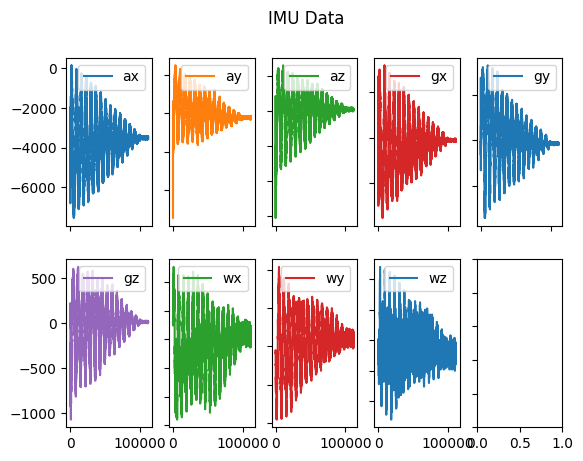

In [9]:
# Preprocessing 9 axis of IMU data
# %matplotlib notebook

imu_ax = [] 
imu_ay = [] 
imu_az = [] 
imu_gx = [] 
imu_gy = [] 
imu_gz = [] 
imu_wx = [] 
imu_wy = [] 
imu_wz = [] 

for i in range(0,len(IMU_Data)):
    imu_ax.append(IMU_Data[i][1][0])
    imu_ay.append(IMU_Data[i][1][1])
    imu_az.append(IMU_Data[i][1][2])
    imu_gx.append(IMU_Data[i][1][3])
    imu_gy.append(IMU_Data[i][1][4])
    imu_gz.append(IMU_Data[i][1][5])
    imu_wx.append(IMU_Data[i][1][6])
    imu_wy.append(IMU_Data[i][1][7])
    imu_wz.append(IMU_Data[i][1][8])
    
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5)
fig.suptitle('IMU Data')
ax1.plot(imu_ax, 'tab:blue', label="ax")
ax1.legend(loc="upper right")
ax2.plot(imu_ay, 'tab:orange', label="ay")
ax2.legend(loc="upper right")
ax3.plot(imu_az, 'tab:green', label="az")
ax3.legend(loc="upper right")
ax4.plot(imu_gx, 'tab:red', label="gx")
ax4.legend(loc="upper right")
ax5.plot(imu_gy, 'tab:blue', label="gy")
ax5.legend(loc="upper right")
ax6.plot(imu_gz, 'tab:purple', label="gz")
ax6.legend(loc="upper right")
ax7.plot(imu_wx, 'tab:green', label="wx")
ax7.legend(loc="upper right")
ax8.plot(imu_wy, 'tab:red', label="wy")
ax8.legend(loc="upper right")
ax9.plot(imu_wz, 'tab:blue', label="wz")
ax9.legend(loc="upper right")

for ax in fig.get_axes():
    ax.label_outer()

# final Data for IMU that we can use it
Data_of_IMU = []
for i in range(0,len(IMU_Data)):
    Data_of_IMU.append((IMU_Data[i][2],IMU_Data[i][1]))

#### Encoder Preprocessing

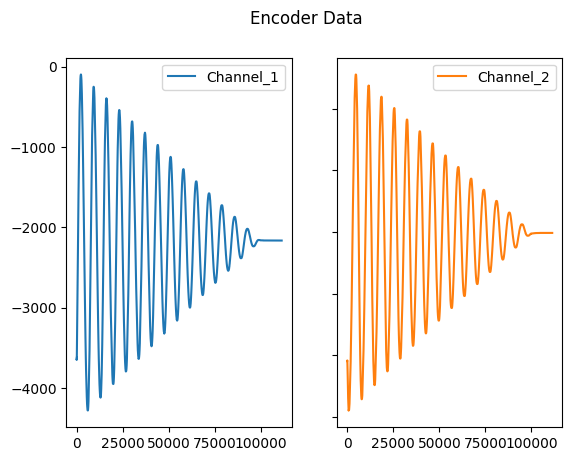

In [10]:
# Encoder Data of two motor
# %matplotlib notebook

Enc_ch1 = []
Enc_ch2 = []

for i in range(0,len(Enc_Data)):
    Enc_ch1.append(Enc_Data[i][1][0])
    Enc_ch2.append(Enc_Data[i][1][1])
fig, ((ax1, ax2)) = plt.subplots(1, 2)
fig.suptitle('Encoder Data')
ax1.plot(Enc_ch1, 'tab:blue', label="Channel_1")
ax1.legend(loc="upper right")
ax2.plot(Enc_ch2, 'tab:orange' ,label="Channel_2")
ax2.legend(loc="upper right")

for ax in fig.get_axes():
    ax.label_outer()    

# final Data for encoder that we can use it
Data_of_Encoder = []
for i in range(0,len(Enc_Data)):
    Data_of_Encoder.append((Enc_Data[i][2],Enc_Data[i][1]))

#### Tourqe Preprocessing

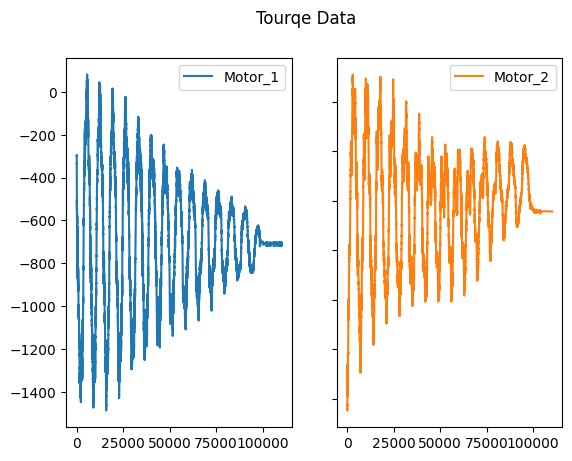

In [11]:
# Tourqe Data of two motor
Tourqe_m1 = []
Tourqe_m2 = []

for i in range(1000,len(Turq_Data)):
    Tourqe_m1.append(Turq_Data[i][1][0])
    Tourqe_m2.append(Turq_Data[i][1][1])
fig, ((ax1, ax2)) = plt.subplots(1, 2)
fig.suptitle('Tourqe Data')
ax1.plot(Tourqe_m1, 'tab:blue', label="Motor_1")
ax1.legend(loc="upper right")
ax2.plot(Tourqe_m2, 'tab:orange' ,label="Motor_2")
ax2.legend(loc="upper right")

for ax in fig.get_axes():
    ax.label_outer()    

# final Data for Tourqe that we can use it
Data_of_Tourqe = []
for i in range(0,len(Turq_Data)):
    Data_of_Tourqe.append((Turq_Data[i][2],Turq_Data[i][1]))


## Camera Data

In [12]:
# find the triggrs time for camera from DAQ and create CameraDAQ_time
CameraDAQ_time=[]
for i in range(0,len(Camera_Data)-1):
    if (Camera_Data[i][1]-Camera_Data[i+1][1])!=0:
        CameraDAQ_time.append(Camera_Data[i][1])
        
# add the last time stamp in tuple
CameraDAQ_time += (Camera_Data[-1][1],)
len(CameraDAQ_time)

2239

In [13]:
# read csv camera time stamp witch caught from RPI and create RPI_time 
file = open("./data/camera_stamps.csv")
csvreader = csv.reader(file)
header = ['sec','nsec']
RPI_time_raw = []
RPI_time = []
for row in csvreader:
    RPI_time_raw.append(row)
file.close()

# repairing the usec data which aren't in 6 number
for i in range(1,len(RPI_time_raw)):
    
    # if it was 5 
    if int(RPI_time_raw[i][2])//10 <= 9999 and int(RPI_time_raw[i][2])//100 >= 100:
        RPI_time_raw[i][2] = '0' + RPI_time_raw[i][2]
    CameraDAQ_time
    # if it was 4 
    if int(RPI_time_raw[i][2])//10 <= 999 and int(RPI_time_raw[i][2])//100 >= 10:
        RPI_time_raw[i][2] = '00' + RPI_time_raw[i][2]
        
    # if it was 3 
    if int(RPI_time_raw[i][2])//10 <= 99 and int(RPI_time_raw[i][2])//100 >= 1:
        RPI_time_raw[i][2] = '000' + RPI_time_raw[i][2]

    # if it was 2 
    if int(RPI_time_raw[i][2])//10 <= 9 and int(RPI_time_raw[i][2])//10 >= 1 and int(RPI_time_raw[i][2])//100 >= 0:
        RPI_time_raw[i][2] = '0000' + RPI_time_raw[i][2]

    # if it was 1 
    if int(RPI_time_raw[i][2])//10 <= 0 and int(RPI_time_raw[i][2])//100 >= 0:
        RPI_time_raw[i][2] = '00000' + RPI_time_raw[i][2]
        
    RPI_time.append(int(RPI_time_raw[i][1]+RPI_time_raw[i][2]))

len(RPI_time)

2378

0.07


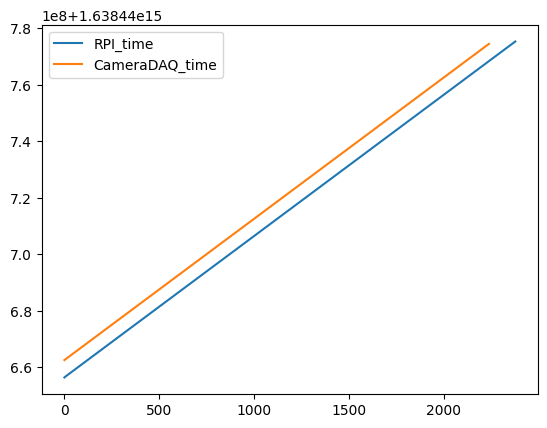

In [14]:
# find nearest number of RPI_time to first CameraDAQ_time
minimum = []
for i in range(0,len(RPI_time)):
    time_differ = []
    for j in range(0,len(CameraDAQ_time)):
        time_differ.append(abs(CameraDAQ_time[j] - RPI_time[i])*10e-3)
    minimum.append(min(time_differ))
print(min(minimum))
# plt.plot(minimum,label = "minimum")
plt.plot(RPI_time,label = "RPI_time")
plt.plot(CameraDAQ_time,label = "CameraDAQ_time")
plt.legend()
plt.show()

### Finding alligments index

49956.54007025523 1638440662572153.5 49956.69006463011 1638440656474275.2
[-122 -121 -120 ... 2114 2115 2116]
alligment_begin = 122 , alligment_end = 2360
well done alligment! It's True!
delay is: 28.649245198749444 mili_sec


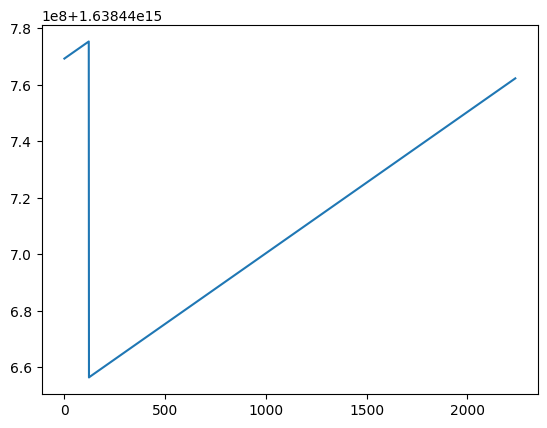

In [15]:
# Fit a line to the camera timestamps indexed in raspberry pi
RPI_time_np = np.array(RPI_time)
pol = np.polyfit([i for i in range(RPI_time_np.shape[0])], RPI_time_np, 1)
m2, b2 = pol
# Fit a line to the camera time stamps indexed in the DAQ
CameraDAQ_time_np = np.array(CameraDAQ_time)
pol = np.polyfit([i for i in range(CameraDAQ_time_np.shape[0])], CameraDAQ_time_np, 1)
m1, b1 = pol
print(m1,b1, m2, b2)
# map function
f = lambda i:(m2*i+b2-b1)/m1
daq_idx_to_rpi_idx_map = np.array([f(i).round().astype(np.compat.long) for i in range(CameraDAQ_time_np.shape[0])])
daq_idx_to_rpi_idx_map = daq_idx_to_rpi_idx_map[np.where([RPI_time_np.shape[0]-1 >= daq_idx_to_rpi_idx_map])[1]]
print(daq_idx_to_rpi_idx_map)
corrected_daq_stamp = RPI_time_np[daq_idx_to_rpi_idx_map.squeeze()]
plt.plot(corrected_daq_stamp)
# the index of camera time stamp from raspberry pi which should be fix on each other 
alligment_begin_mapping = abs(daq_idx_to_rpi_idx_map[0])

# find the beging and ending of RPI_time index alligment to our CaemeraDAQ_time
test_begin_allig = []
test_end_allig = []
for i in range(0,len(RPI_time)):
    test_begin_allig.append(abs(CameraDAQ_time[0]-RPI_time[i]))
    test_end_allig.append(abs(CameraDAQ_time[-1]-RPI_time[i]))
alligment_begin = test_begin_allig.index(min(test_begin_allig))
alligment_end = test_end_allig.index(min(test_end_allig))
print('alligment_begin =', alligment_begin,', alligment_end =',alligment_end)

# check if the beging alligment from mapping and minimizing time are same or not
if alligment_begin_mapping == alligment_begin:
    print("well done alligment! It's True!")
else:
    print("Alligment have a problem")
    
# this section calculate the avverage difference time between RPI_time 
# and CameraDAQ_time by the found alligments
RPI_time_cuted_two_side = []
delay = 0
for i in range(alligment_begin,alligment_end+1):
    RPI_time_cuted_two_side.append(RPI_time[i])
for i in range(0,len(CameraDAQ_time)):
    delay = delay + abs(CameraDAQ_time[i]-RPI_time_cuted_two_side[i])
print("delay is:",(delay*10e-3)/len(CameraDAQ_time), "mili_sec")

### Create detector_input bag file

In [16]:
# raw_camera.bag have msg and we want to change the time stamp
# camera+time.bag is the output with time stamp
i=0
j=0
with rosbag.Bag('./data/camera+time.bag', 'w') as outbag:
    for topic, msg, t in rosbag.Bag('./data/raw_camera.bag').read_messages():
        if topic == ('/mono_camera/image_raw'):
            msg.header.stamp.secs = RPI_time[i]//1000000
            msg.header.stamp.nsecs = RPI_time[i]%(RPI_time[i]//1000000)
            outbag.write(topic, msg ,t)
            i=i+1
        
        if topic == ('/mono_camera/cameraInfo'):
            msg.header.stamp.secs = RPI_time[j]//1000000
            msg.header.stamp.nsecs = RPI_time[j]%(RPI_time[j]//1000000)
            outbag.write(topic, msg ,t)
            j=j+1         
print('i =', i,', j =',j)

# This section we check if the seq number that we want to cut bag file by them are 
# true ot not, so to know, we check the time of the message bag from seq by the RPI_time
for topic, msg, t in rosbag.Bag('./data/camera+time.bag').read_messages():
    if topic == ('/mono_camera/image_raw'):
        if msg.header.stamp.secs == RPI_time[alligment_begin]//1000000 and msg.header.stamp.nsecs == RPI_time[alligment_begin]%(RPI_time[alligment_begin]//1000000):
            if alligment_begin + 1 == msg.header.seq:
                print("right_hand_cut is true")
            else:
                print("right_hand_cut has a problem!!!!!!!!!!!")
                
        if msg.header.stamp.secs == RPI_time[alligment_end]//1000000 and msg.header.stamp.nsecs == RPI_time[alligment_end]%(RPI_time[alligment_end]//1000000):
            if alligment_end + 1 == msg.header.seq:
                print("left_hand_cut is true")
            else:
                print("left_hand_cut has a problem!!!!!!!!!!!")

# we sould create a new bag file from camera+time (this time came from RPI_time) with named
# sliced that start from begining_time
with rosbag.Bag('./data/cuted_camera+time.bag', 'w') as outbag:
    for topic, msg, t in rosbag.Bag('./data/camera+time.bag').read_messages():
        if msg.header.seq > alligment_begin and msg.header.seq < alligment_end + 2:
            outbag.write(topic, msg, t)
            
# now the CameraDAQ_time should be writen in cuted_camera+time
# this part create the input of detector algotithm
# the detector_input have a lengh of CameraDAQ_time
m=0
n=0
with rosbag.Bag('./data/detector_input.bag', 'w') as outbag:
    for topic, msg, t in rosbag.Bag('./data/cuted_camera+time.bag').read_messages():
        if topic == ('/mono_camera/image_raw'):
            msg.header.stamp.secs = CameraDAQ_time[m]//1000000
            msg.header.stamp.nsecs = CameraDAQ_time[m]%(CameraDAQ_time[m]//1000000)
            outbag.write(topic, msg ,t)
            m=m+1      
        if topic == ('/mono_camera/cameraInfo'):
            msg.header.stamp.secs = CameraDAQ_time[n]//1000000
            msg.header.stamp.nsecs = CameraDAQ_time[n]%(CameraDAQ_time[n]//1000000)
            outbag.write(topic, msg ,t)
            n=n+1  
print('m =', m,', n =',n)

i = 2374 , j = 2374
right_hand_cut is true
left_hand_cut is true
m = 2239 , n = 2239


# TagSlam Data

### Extract TagSlam Data

In [17]:
# extract the camera data (time, translation and quaternion) from rosbag messages
Slam_time_without_repairing = []
traslation = []
quaternion_param = []
bag = rosbag.Bag('./data/out.bag')
for (topic, msg, t) in bag.read_messages(topics=['/tagslam/odom/body_rig']):
#     print(msg)
    Slam_time_without_repairing.append((msg.header.stamp.secs,msg.header.stamp.nsecs))
    traslation.append((msg.pose.pose.position.x,msg.pose.pose.position.y,msg.pose.pose.position.z))
    quaternion_param.append((msg.pose.pose.orientation.x,msg.pose.pose.orientation.y,msg.pose.pose.orientation.z,msg.pose.pose.orientation.w))
print(len(quaternion_param))

2034


### Preprocessing Data

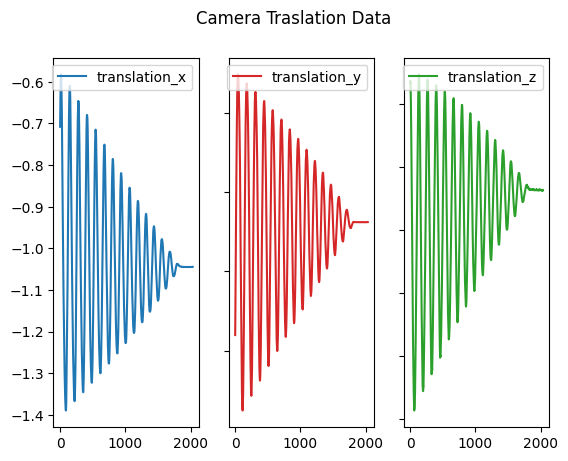

In [18]:
# %matplotlib notebook

translation_x = []
translation_y = []
translation_z = []

for i in range(0,len(traslation)):
    translation_x.append(traslation[i][0])
    translation_y.append(traslation[i][1])
    translation_z.append(traslation[i][2])
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Camera Traslation Data')
ax1.plot(translation_x, 'tab:blue', label="translation_x")
ax1.legend(loc="upper right")
ax2.plot(translation_y, 'tab:red', label="translation_y")
ax2.legend(loc="upper right")
ax3.plot(translation_z, 'tab:green', label="translation_z")
ax3.legend(loc="upper right")

for ax in fig.get_axes():
    ax.label_outer()   
    

### Repairing Camera_Time

In [19]:
# repairing the usec data which aren't in in 6 number
SLAM_TIME = []
for i in range(0,len(Slam_time_without_repairing)):
    
    # if it was 6 
    if int(Slam_time_without_repairing[i][1])//10 <= 99999 and int(Slam_time_without_repairing[i][1])//100 >= 1000:
        SLAM_TIME.append(int(str(Slam_time_without_repairing[i][0]) + str(Slam_time_without_repairing[i][1])))
    
    # if it was 5 
    if int(Slam_time_without_repairing[i][1])//10 <= 9999 and int(Slam_time_without_repairing[i][1])//100 >= 100:
        SLAM_TIME.append(int(str(Slam_time_without_repairing[i][0]) + '0' + str(Slam_time_without_repairing[i][1])))
    
    # if it was 4 
    if int(Slam_time_without_repairing[i][1])//10 <= 999 and int(Slam_time_without_repairing[i][1])//100 >= 10:
        SLAM_TIME.append(int(str(Slam_time_without_repairing[i][0]) + '00' + str(Slam_time_without_repairing[i][1])))
        
    # if it was 3 
    if int(Slam_time_without_repairing[i][1])//10 <= 99 and int(Slam_time_without_repairing[i][1])//100 >= 1:
        SLAM_TIME.append(int(str(Slam_time_without_repairing[i][0]) + '000' + str(Slam_time_without_repairing[i][1])))

    # if it was 2 
    if int(Slam_time_without_repairing[i][1])//10 <= 9 and int(Slam_time_without_repairing[i][1])//10 >= 1 and int(Slam_time_without_repairing[i][1])//100 >= 0:
        SLAM_TIME.append(int(str(Slam_time_without_repairing[i][0]) + '0000' + str(Slam_time_without_repairing[i][1])))

    # if it was 1 
    if int(Slam_time_without_repairing[i][1])//10 <= 0 and int(Slam_time_without_repairing[i][1])//100 >= 0:
        SLAM_TIME.append(int(str(Slam_time_without_repairing[i][0]) + '00000' + str(Slam_time_without_repairing[i][1])))
        
len(SLAM_TIME)

2034

### Building camera rotation and translation matrix beside it's time

In [20]:
# here we build the rotation matrix with the time in index zero by eatch data
from pyquaternion import Quaternion
Data_of_Cam_Rot_Time = []
for i in range(0,len(quaternion_param)):
    Data_of_Cam_Rot_Time.append((SLAM_TIME[i],Quaternion(quaternion_param[i][3], quaternion_param[i][0], quaternion_param[i][1], quaternion_param[i][2]).rotation_matrix))
    pass
# Also here we create the translation vector by it's time in index zero
Data_of_Cam_Trans_Time = []
for i in range(0,len(quaternion_param)):
    Data_of_Cam_Trans_Time.append((SLAM_TIME[i],(translation_x[i],translation_y[i],translation_z[i])))

# Searching in Encoder Data for Rotation Times

In [76]:
# in this section we create an array that have the rotation matrix and encoder value in same time stamp
Temp = []
Data_of_Rotation_and_Encoder = []
for i in range(0,len(Data_of_Cam_Rot_Time)):  # i---> camera time stamp index
    for j in range(0,len(Data_of_Encoder)): # j---> encoder time stamp index
         Temp.append(abs(Data_of_Cam_Rot_Time[i][0]-Data_of_Encoder[j][0]))
    Data_of_Rotation_and_Encoder.append((Data_of_Cam_Rot_Time[i][0],Data_of_Encoder[Temp.index(min(Temp))][0],Data_of_Cam_Rot_Time[i][1],((Data_of_Encoder[Temp.index(min(Temp))][1][0]*0.0168)*math.pi/180,(Data_of_Encoder[Temp.index(min(Temp))][1][1]*-0.0129)*math.pi/180)))
    # Data_of_Rotation_and_Encoder.append((Data_of_Cam_Rot_Time[i][0],Data_of_Encoder[Temp.index(min(Temp))][0],Data_of_Cam_Rot_Time[i][1],((Data_of_Encoder[Temp.index(min(Temp))][1][0]*0.0168+180)*math.pi/180,(Data_of_Encoder[Temp.index(min(Temp))][1][1]*-0.0129+78)*math.pi/180)))
    Temp=[]
Data_of_Rotation_and_Encoder = pd.DataFrame(Data_of_Rotation_and_Encoder)
Data_of_Rotation_and_Encoder.columns = ["CameraTimeStamp","EncoderTimeStamp","RotationMatrix","EncoderValue"]
display(Data_of_Rotation_and_Encoder)
Data_of_Rotation_and_Encoder = np.array(Data_of_Rotation_and_Encoder)
Data_of_Rotation_and_Encoder.shape
np.save('./result/Data_of_Rotation_and_Encoder', Data_of_Rotation_and_Encoder)

,CameraTimeStamp,EncoderTimeStamp,RotationMatrix,EncoderValue
0,1638440662621938,1638440662619430,"[[-0.9743420560977512, -0.17094320361534052, 0...","(-1.0643715910362217, -0.43138255923992647)"
1,1638440662671891,1638440662671434,"[[-0.9756213835750127, -0.16853634482129112, 0...","(-1.0608530072642013, -0.4277801996638102)"
2,1638440662721847,1638440662721437,"[[-0.9777638531822879, -0.16683353534133274, 0...","(-1.0318246911450317, -0.4140462037798668)"
3,1638440662771802,1638440662771442,"[[-0.9801025990838758, -0.16254396996291268, 0...","(-1.0013302984541868, -0.39490866853174894)"
4,1638440662821761,1638440662821447,"[[-0.9823100773900388, -0.1566471815069952, 0....","(-0.9816848723937385, -0.38590276959145825)"
...,...,...,...,...
2029,1638440774174928,1638440774175014,"[[-0.8337505160435061, 0.310627168607542, 0.45...","(-0.6348111555353776, -0.8974378293999723)"
2030,1638440774224889,1638440774225017,"[[-0.8336971970306428, 0.3106507381973548, 0.4...","(-0.6345179402210425, -0.8974378293999723)"
2031,1638440774274845,1638440774275022,"[[-0.8336839795780233, 0.3106431998860328, 0.4...","(-0.6348111555353776, -0.8974378293999723)"
2032,1638440774324802,1638440774325031,"[[-0.8337016348571832, 0.31062453370413395, 0....","(-0.6348111555353776, -0.8974378293999723)"


# Rotation Matrix base on alpha and beta 

## This is used for first factor graph

In [74]:
# DeltaMatCamera,DeltaMatKinematic = Cross(Data_of_Rotation_and_Encoder[:,2],Data_of_Rotation_and_Encoder[:,3], 20)

# # save data in .npy file
# np.save('./result/DeltaMatCamera', DeltaMatCamera)
# np.save('./result/DeltaMatKinemprintatic', DeltaMatKinematic)

# # # load data from .npy file
# # DeltaMatCamera = np.load('DeltaMatCamera.npy')
# # DeltaMatKinematic = np.load('DeltaMatKinematic.npy' , allow_pickle=True)

# Rotation Matrix base on alpha and beta

## This is used for second factor graph

In [77]:
GT_data_and_joint_values = data_collection_for_factor_graph_base_on_symforce(Data_of_Rotation_and_Encoder[:,2],Data_of_Rotation_and_Encoder[:,3], 20)

file_name = "./result/GT_data_and_joint_values_for_factor_graph_base_on_symforce.csv"

with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    
    # Write the data from the list to the CSV file
    for row in GT_data_and_joint_values:
        writer.writerow(row)
        
file.close()

# Analysing the error for alpha and beta catched from FactorGraph

In [24]:
DeltaMatCamera,DeltaMatKinematic_nom = Cross_with_alpha_beta(Data_of_Rotation_and_Encoder[:,2],Data_of_Rotation_and_Encoder[:,3], 15, math.pi/4, math.pi/4)

In [25]:
alpha = 42.9006
beta = 47.122
print(f"\nalpha is {alpha}, and beta is {beta}\n")
DeltaMatCamera,DeltaMatKinematic_iden = Cross_with_alpha_beta(Data_of_Rotation_and_Encoder[:,2],Data_of_Rotation_and_Encoder[:,3], 15, math.pi/180 * alpha , math.pi/180 * beta)


alpha is 42.9006, and beta is 47.122



In [26]:
error_nom_scrow = []
error_iden_scrow = []
error_nom_frob = []
error_iden_frob = []
error_nom_meanmat = []
error_iden_meanmat = []
deltaR_NOM = []
deltaR_IDEN = []

# print(f"\nalpha is {alpha}, and beta is {beta}\n")

for i in range(len(DeltaMatCamera)):
    deltaR_NOM.append(re(sym.Matrix(np.transpose(DeltaMatKinematic_nom[i]) * DeltaMatCamera[i])))
    deltaR_IDEN.append(re(sym.Matrix(np.transpose(DeltaMatKinematic_iden[i]) * DeltaMatCamera[i])))
    error_nom_scrow.append(np.rad2deg(np.arccos((float(np.trace(deltaR_NOM[i])) - 1) / 2)))
    error_iden_scrow.append(np.rad2deg(np.arccos((float(np.trace(deltaR_IDEN[i])) - 1) / 2)))
    error_nom_meanmat.append(np.mean(deltaR_NOM[i]))
    error_iden_meanmat.append(np.mean(deltaR_IDEN[i]))
    error_nom_frob.append(deltaR_NOM[i].norm(oo))
    error_iden_frob.append(deltaR_IDEN[i].norm(oo))

cleaned_vector_nom = [x for x in error_nom_scrow if not np.isnan(x)]
cleaned_vector_iden = [x for x in error_iden_scrow if not np.isnan(x)]

print("error nom in scrow : " , np.mean(cleaned_vector_nom))
print("error iden in scrow : " , np.mean(cleaned_vector_iden))
print("\nerror nom in mean matrix : " , np.mean(error_nom_meanmat))
print("error iden in mean matrix : " , np.mean(error_iden_meanmat))
print("\nerror nom in frobenious : " , np.mean(error_nom_frob))
print("error iden in frobenious : " , np.mean(error_iden_frob))

/tmp/ipykernel_43708/6259694.py:15: RuntimeWarning: invalid value encountered in arccos
  error_nom_scrow.append(np.rad2deg(np.arccos((float(np.trace(deltaR_NOM[i])) - 1) / 2)))
/tmp/ipykernel_43708/6259694.py:16: RuntimeWarning: invalid value encountered in arccos
  error_iden_scrow.append(np.rad2deg(np.arccos((float(np.trace(deltaR_IDEN[i])) - 1) / 2)))


error nom in scrow :  8.166997449087985
error iden in scrow :  7.887685313719497

error nom in mean matrix :  0.327897622354314
error iden in mean matrix :  0.327962289759897

error nom in frobenious :  1.15525013041836
error iden in frobenious :  1.15399144797952


In [27]:
# print(f"\nalpha is {alpha}, and beta is {beta}\n")

deltaR_camera_axis = []
deltaR_camera_angle = []
deltaR_camera_angle_axis = []

deltaR_FK_NOM_axis = []
deltaR_FK_NOM_angle = []
deltaR_FK_NOM_angle_axis = []

deltaR_FK_IDEN_axis = []
deltaR_FK_IDEN_angle = []
deltaR_FK_IDEN_angle_axis = []

Vector_Error_vector_NOM = []
Vector_Error_vector_IDEN = []

Vector_Error_num_NOM = []
Vector_Error_num_IDEN = []

for i in range(1700):
    
    deltaR_camera_axis.append(Quaternion(matrix=DeltaMatCamera[i]).axis)
    deltaR_camera_angle.append(Quaternion(matrix=DeltaMatCamera[i]).radians)
    deltaR_camera_angle_axis.append(deltaR_camera_angle[i] * deltaR_camera_axis[i])

    deltaR_FK_NOM_axis.append(Quaternion(matrix=np.array(re(sym.Matrix(DeltaMatKinematic_nom[i]))).astype(float)).axis)
    deltaR_FK_NOM_angle.append(Quaternion(matrix=np.array(re(sym.Matrix(DeltaMatKinematic_nom[i]))).astype(float)).radians)
    deltaR_FK_NOM_angle_axis.append(deltaR_FK_NOM_angle[i] * deltaR_FK_NOM_axis[i])

    deltaR_FK_IDEN_axis.append(Quaternion(matrix=np.array(re(sym.Matrix(DeltaMatKinematic_iden[i]))).astype(float)).axis)
    deltaR_FK_IDEN_angle.append(Quaternion(matrix=np.array(re(sym.Matrix(DeltaMatKinematic_iden[i]))).astype(float)).radians)
    deltaR_FK_IDEN_angle_axis.append(deltaR_FK_IDEN_angle[i] * deltaR_FK_IDEN_axis[i])
    
    Vector_Error_vector_NOM.append(deltaR_FK_NOM_angle_axis[i] - deltaR_camera_angle_axis[i])
    Vector_Error_vector_IDEN.append(deltaR_FK_IDEN_angle_axis[i] - deltaR_camera_angle_axis[i])
    
    Vector_Error_num_NOM.append(np.linalg.norm(Vector_Error_vector_NOM[i], ord=2))
    Vector_Error_num_IDEN.append(np.linalg.norm(Vector_Error_vector_IDEN[i], ord=2))
    
print("erro nom: ", np.mean(Vector_Error_num_NOM))
print("erro iden: ", np.mean(Vector_Error_num_IDEN))
improve = (np.mean(Vector_Error_num_NOM) - np.mean(Vector_Error_num_IDEN))/np.mean(Vector_Error_num_NOM) *100
print("improvment percent = ", improve, "%")

    

erro nom:  0.16389928750901853
erro iden:  0.16175196354285362
improvment percent =  1.3101484446945801 %
